# **🩺 Federated Learning Tutorial: Malaria Diagnosis**

**Women in AI Nigeria Workshop**

**Facilitator**: Dr. Sakinat Folorunso

Associate Professor of AI Systems & FAIR Data

Department of Computer Sciences

Olabisi Onabanjo University



** Welcome!**

This interactive notebook introduces Federated Learning (FL) using the Flower framework. You'll learn how multiple simulated clinics (clients) collaboratively train a machine learning model for malaria diagnosis, without
sharing sensitive patient data.



**What You’ll Learn**

1. Load and explore a synthetic malaria dataset simulating 3 clinics.

2. Perform Exploratory Data Analysis (EDA).
3.
Build a dense neural network in TensorFlow.
4.
Simulate federated training rounds using Flower’s FedAvg strategy.
5.
Visualize global performance over training rounds.
6.
Generate a classification report and confusion matrix for model evaluation.
7. Customize neural network architecture interactively.
8.
Simulate multiple clinics (clients).
9.
Understand privacy-preserving AI concepts.
10.
Visualize training results and evaluate performance.



**Why Federated Learning?**
In healthcare, sharing raw data between hospitals can compromise patient privacy. Federated Learning allows collaborative training without sharing data, preserving privacy and enhancing security.


Let’s begin our journey into privacy-preserving AI in healthcare and other application areas!

# **Step 1: Install Libraries**

Install essential Python libraries: Flower for federated learning, TensorFlow for building the model, Pandas for data manipulation, Matplotlib for visualization, and Scikit-learn for evaluation.

In [1]:

# Step 1: Install Libraries
!pip install -q flwr[simulation] pandas matplotlib scikit-learn tensorflow ipywidgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import flwr as fl
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
pyopenssl

# **Step 2: Load and Inspect the Malaria Dataset**

We load a synthetic malaria dataset simulating 3 clinics (clients). Explore the data structure and initial content.

In [2]:
# prompt: code to mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



**Load Real-World Datasets**

⚠️ Ensure ethical approval before using real-world datasets. Format data to match input features:

- age, temperature, parasite_density, rbc_count, wbc_count, headache, fever, malaria_positive


In [3]:
import pandas as pd                                         # For data loading & manipulation

# Load our previously exported mock malaria CSV file
df = pd.read_csv('/content/drive/My Drive/WAI Workshop FedLearn/Federated_malaria_dataset.csv')

# Print total number of records and list of simulated client IDs
print(f"Total records: {len(df)}")
print("Clients:", df.client_id.unique())

# Show the first five rows to verify column names & sample values
df.head()


Total records: 150
Clients: ['clinic_1' 'clinic_2' 'clinic_3']


,client_id,age,temperature,parasite_density,rbc_count,wbc_count,headache,fever,malaria_positive
0,clinic_1,24,35.6,3,5.42,10.20,0,1,0
1,clinic_1,28,36.5,14,4.33,5.17,0,1,1
2,clinic_1,35,36.0,12,4.12,8.89,1,0,1
3,clinic_1,36,36.6,13,4.39,5.48,1,1,1
4,clinic_1,24,37.7,11,4.64,3.32,0,1,1


# **Step 3: Exploratory Data Analysis (EDA)**

Analyze class distribution and visualize patient data like age, temperature, and parasite density to understand patterns in the dataset.

In [5]:
# Specify which columns are features vs. the target label
feature_cols = ['age','temperature','parasite_density','rbc_count','wbc_count','headache','fever']
label_col   = 'malaria_positive'

# Display data types and check for any missing values
df.info()

# Show summary statistics (mean, std, min, max, quartiles)
df[feature_cols + [label_col]].describe().round(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         150 non-null    object 
 1   age               150 non-null    int64  
 2   temperature       150 non-null    float64
 3   parasite_density  150 non-null    int64  
 4   rbc_count         150 non-null    float64
 5   wbc_count         150 non-null    float64
 6   headache          150 non-null    int64  
 7   fever             150 non-null    int64  
 8   malaria_positive  150 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 10.7+ KB


,age,temperature,parasite_density,rbc_count,wbc_count,headache,fever,malaria_positive
count,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00
mean,29.57,36.92,19.15,4.45,6.14,0.48,0.69,0.92
std,10.03,1.32,8.74,0.47,2.03,0.50,0.47,0.27
min,1.00,34.20,3.00,3.40,0.43,0.00,0.00,0.00
25%,23.00,35.90,11.00,4.16,4.88,0.00,0.00,1.00
50%,30.00,36.95,20.00,4.43,6.18,0.00,1.00,1.00
75%,37.00,37.88,25.00,4.75,7.52,1.00,1.00,1.00
max,53.00,40.40,42.00,5.65,10.47,1.00,1.00,1.00


# **Step 4: Data Preprocessing - Split per Client**

Each clinic will act as a federated client. We split each clinic’s data into local train/test sets.

Records per client:
 client_id
clinic_1    50
clinic_2    50
clinic_3    50
Name: count, dtype: int64 

Overall label distribution (%):
malaria_positive
1    92.0
0     8.0
Name: proportion, dtype: float64 %



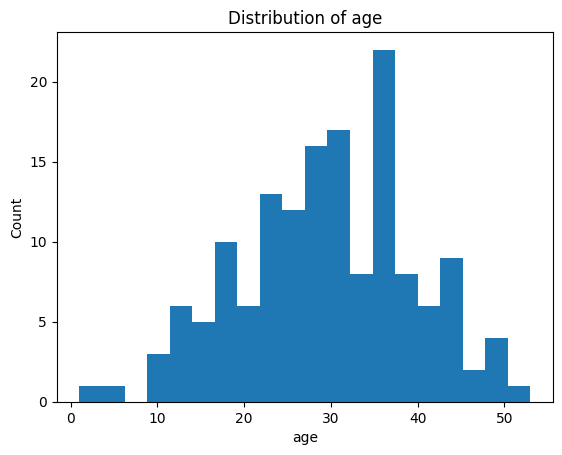

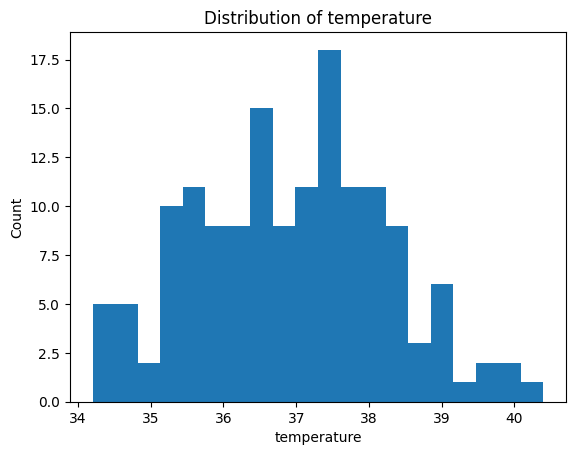

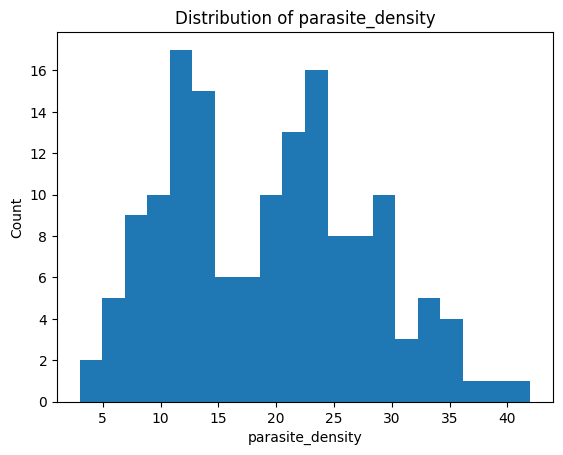

In [6]:
import matplotlib.pyplot as plt                              # For plotting

# Count how many records each clinic/client has
print("Records per client:\n", df.client_id.value_counts(), "\n")

# Show overall percentage of positive vs. negative labels
print("Overall label distribution (%):")
print(df[label_col].value_counts(normalize=True).mul(100).round(1), "%\n")

# For key features, draw histograms to see their distributions
for col in ['age','temperature','parasite_density']:
    plt.figure()                                            # Start a new figure
    plt.hist(df[col], bins=20)                              # Histogram with 20 bins
    plt.title(f"Distribution of {col}")                     # Title for context
    plt.xlabel(col)                                         # X-axis label
    plt.ylabel("Count")                                     # Y-axis label
    plt.show()                                              # Render the plot


In [10]:
from sklearn.model_selection import train_test_split        # For train/test splitting
import numpy as np                                          # For numeric arrays

# Get a list of unique client IDs (e.g. ['clinic_1','clinic_2','clinic_3'])
client_ids = df.client_id.unique().tolist()

# Prepare dictionaries to hold each client’s local train/test data
client_train_data = {}
client_test_data  = {}

# Iterate over each client to split its data
for cid in client_ids:
    df_c = df[df.client_id == cid]                         # Filter rows for this client
    X = df_c[feature_cols].values.astype(np.float32)       # Features as float32 array
    y = df_c[label_col].values.astype(np.int32)            # Labels as int32 array

    # Stratify on y to preserve class balance in train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,                                      # 20% held out for testing
        random_state=42,                                   # For reproducibility
        # Removed stratify=y because of the small number of minority class samples per client
    )

    # Store each split in our dictionaries
    client_train_data[cid] = (X_train, y_train)
    client_test_data[cid]  = (X_test,  y_test)

# Confirm which clients have been prepared
print("Clients prepared:", client_ids)

Clients prepared: ['clinic_1', 'clinic_2', 'clinic_3']


# **Step 5: Build Malaria Diagnosis Model**

Define a simple dense neural network classifier using TensorFlow to predict malaria positivity.

In [13]:
import tensorflow as tf                                    # For building neural networks

# 🛠️ Step 5: Neural Network - Widget Customization
num_layers = widgets.IntSlider(value=2, min=1, max=4, description='Hidden Layers:')
layer_units = widgets.Text(value='32,16', description='Units per Layer:')
activation_fn = widgets.Dropdown(
    options=['relu', 'tanh', 'sigmoid'], value='relu', description='Activation:'
)
display(num_layers, layer_units, activation_fn)

def build_malaria_model(input_shape):
    """Create and compile a simple dense network for binary classification."""
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),   # Define input dimensions
        tf.keras.layers.Dense(32, activation="relu"),          # Hidden layer with 32 units
        tf.keras.layers.Dense(16, activation="relu"),          # Another hidden layer
        tf.keras.layers.Dense(1, activation="sigmoid"),        # Output layer for 0/1 prediction
    ])
    model.compile(
        optimizer="adam",                                       # Adam optimizer
        loss="binary_crossentropy",                             # Loss for two classes
        metrics=["accuracy"],                                   # Track accuracy metric
    )
    return model

# Instantiate and display the model architecture
model = build_malaria_model(input_shape=(len(feature_cols),))
model.summary()

IntSlider(value=2, description='Hidden Layers:', max=4, min=1)

Text(value='32,16', description='Units per Layer:')

Dropdown(description='Activation:', options=('relu', 'tanh', 'sigmoid'), value='relu')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

# **Step 6: Setup Federated Learning Client**

Each clinic trains locally and communicates updates (not raw data) with the central server via the Flower framework.

In [15]:
import flwr as fl                                          # Flower federated learning framework

class MalariaClient(fl.client.NumPyClient):
    """Flower client for local training & evaluation on one clinic’s data."""
    def __init__(self, cid):
        # Map the string ID (“0”/“1”/“2”) to our clinic labels
        self.client_label = client_ids[int(cid)]
        # Build a fresh model for this client
        self.model = build_malaria_model(input_shape=(len(feature_cols),))
        # Load this client’s train & test splits
        self.X_train, self.y_train = client_train_data[self.client_label]
        self.X_test,  self.y_test  = client_test_data[self.client_label]

    def get_parameters(self, config):
        """Return current local model weights."""
        return self.model.get_weights()

    def fit(self, parameters, config):
        """Receive global weights, train locally for one epoch, return updated weights."""
        self.model.set_weights(parameters)                   # Load global model
        self.model.fit(
            self.X_train, self.y_train,
            epochs=1,                                        # Single local epoch
            batch_size=16,
            verbose=0                                        # Silent training
        )
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        """Receive global weights, evaluate on local test set."""
        self.model.set_weights(parameters)                   # Load global model
        loss, acc = self.model.evaluate(
            self.X_test, self.y_test,
            verbose=0                                        # Silent eval
        )
        return loss, len(self.X_test), {"accuracy": acc}

# **Step 7: Run Federated Learning**

Using the FedAvg strategy, simulate federated training across all clinics for 5 collaborative rounds.

In [19]:
# 🚀 Step 7: Run Federated Learning
client_slider = widgets.IntSlider(value=3, min=1, max=10, description='Simulated Clients:')
display(client_slider)


# Define metric aggregation function
def weighted_average(metrics):
    """Aggregate evaluation metrics using weighted average."""
    # Calculate weighted average of accuracy
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, m in metrics]
    return {"accuracy": sum(accuracies) / sum(examples)}

# Choose FedAvg as our aggregation strategy
strategy = fl.server.strategy.FedAvg(
    evaluate_metrics_aggregation_fn=weighted_average,  # Pass the aggregation function
)

# Start simulation: capture history and final global weights
history = fl.simulation.start_simulation(
    client_fn=lambda cid: MalariaClient(cid),              # Instantiate each client
    num_clients=len(client_ids),                           # Number of simulated clients
    config=fl.server.ServerConfig(num_rounds=5),           # Total federated rounds
    strategy=strategy,                                     # FedAvg aggregation
    # return_weights=True                                    # Return final weights - Removed as it's not a valid argument
)

IntSlider(value=3, description='Simulated Clients:', max=10, min=1)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2025-07-22 03:46:48,379	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3983109734.0, 'node:172.28.0.12': 1.0, 'memory': 7966219470.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_c

# **📊 Step 8: Plot Global Model Accuracy**

Visualize global model test accuracy over training rounds to monitor learning progress.

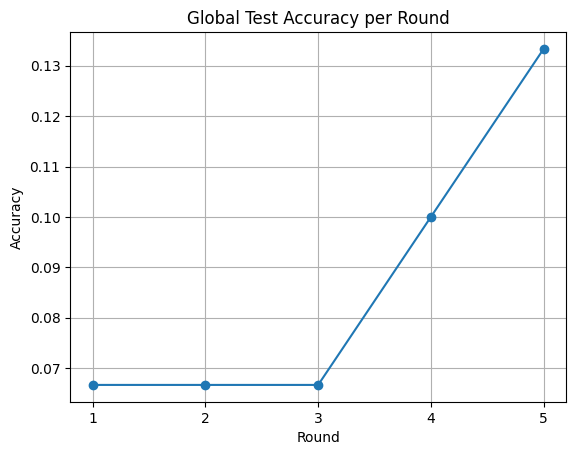

In [24]:
import matplotlib.pyplot as plt

# Prepare x-axis as round numbers and y-axis as accuracy values
rounds = [round for round, accuracy in history.metrics_distributed["accuracy"]]
accuracies = [accuracy for round, accuracy in history.metrics_distributed["accuracy"]]

# Plot and label
plt.plot(rounds, accuracies, marker="o")
plt.title("Global Test Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(rounds)
plt.grid(True)
plt.show()

# 🧮 Step 9: Generating the Classification Report & Confusion Matrix

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Classification Report:

              precision    recall  f1-score   support

    Negative       0.07      1.00      0.14         2
    Positive       1.00      0.11      0.19        28

    accuracy                           0.17        30
   macro avg       0.54      0.55      0.17        30
weighted avg       0.94      0.17      0.19        30



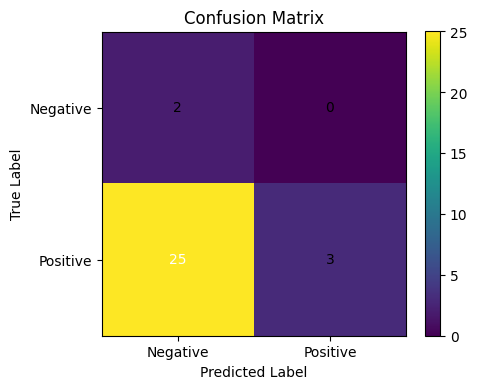

In [26]:
# After the simulation, all clients have the final aggregated model weights.
# We can get the weights from any client to evaluate the global model.
# For simplicity, we will instantiate a client and get its weights after the simulation.
# In a real-world scenario, the server would provide the final aggregated model.
temp_client = MalariaClient(cid='0') # Instantiate a temporary client
final_weights = temp_client.get_parameters({}) # Get the weights from the client

global_model = build_malaria_model(input_shape=(len(feature_cols),))
global_model.set_weights(final_weights)

y_true, y_pred = [], []
for cid in client_ids:
    X_test, y_test = client_test_data[cid]
    preds = (global_model.predict(X_test) > 0.5).astype(int).flatten()
    y_true.extend(y_test.tolist())
    y_pred.extend(preds.tolist())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
classes = ["Negative", "Positive"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

The code in cell above executed without a Python error, but the classification report and confusion matrix show that the model's performance is very poor, especially in identifying "Negative" cases. This is likely due to the small size and significant imbalance of the dataset, where there are many more "Positive" samples than "Negative" ones, making it difficult for the model to learn to correctly classify the minority class.

To improve the model's performance, you could consider:

**Addressing Data Imbalance:** Techniques like oversampling the minority class, undersampling the majority class, or using synthetic data generation methods (like SMOTE) could help.

**Adjusting Model Architecture:** Experimenting with a different neural network architecture or adding regularization might improve learning on this dataset.

**Increasing Data Size:** If possible, using a larger and more balanced dataset would significantly help the model learn more effectively.

In [27]:
print(dir(history))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_loss_centralized', 'add_loss_distributed', 'add_metrics_centralized', 'add_metrics_distributed', 'add_metrics_distributed_fit', 'losses_centralized', 'losses_distributed', 'metrics_centralized', 'metrics_distributed', 'metrics_distributed_fit']


🎉 Congratulations!

You’ve completed the Federated Learning simulation for malaria diagnosis!

You can now explore further by:

1. Trying different neural network architectures.
2. Simulating more clients (clinics).
3. Using real-world datasets (with ethical approval).

Thank you for participating in the Women in AI Nigeria Workshop!